# Introduction 

The following notebook provides a comprehensive overview and implementation of the [Private Aggregation of Teacher Ensembles (PATE)](https://arxiv.org/pdf/1610.05755.pdf) using [PyTorch](https://pytorch.org/) and [PySyft](https://github.com/OpenMined/PySyft). The dataset that is used is [Home Credit Default Dataset](https://www.kaggle.com/c/home-credit-default-risk/overview) which contains features about credit applicants drawn from the internal operations of a financial insititution as well as corresponding Credit Bureau data. The target is whether or not the appliant will default on their debt. The following sections contain a detailed a theoretical overview and subsequent implementation.

# Background

## Private AI

### Introduction to Private AI
A major concern of production machine learning systems is maintaining the privacy of the data that was used to train it. This is especially relevant in use cases with private and sensitive information. In the Private AI literature, a party looking to reveal information about the data that a model is trained on is called an adversary. Even if the adversary does not have access to the data explicitly, access to the model and/or its outputs can reveal information about the data that the model was trained on.

### Privacy Attacks
An adversary employs a privacy attack in order to reveal information about the data that the model was trained on. Two attacks that are well researched in the Private AI Literature: 
- **Model Inversion Attack:** Try to obtain information about typical samples in the training dataset. This involves attacks that euther reconst a specific sample or representative samples in the training dataset. 

- **Membership Inference Attack:** Try to ascertain whether or not a sample was used to train a model. 

### Threat Models
Each adversary has a threat model that informs the manner in which they go about a privacy attack. The threat model describes the level of access that an adverary has to a model. At a high level, there are two threat models: 
- **Black Box Adversary:** Solely able to query the model. Thus, the only information made available to the adversary is the inputs and outputs of the model. 
- **White Box Adversary:** The adversary is able to query the model as well as have access to its internal parameters. This implies that the adversary has access to the input, output and the intermediate computations made by the model. 

## Differential Privacy 

### Introduction to Differential Privacy
In order to evaluate the robustness of a model to privacy attacks, we have to define a framework through which we can obtain a quantitative measure that describes its performance in terms of privacy. To this end, Differential Privacy has been proposed and offers a powerful mechanism to assess and rank the privacy of models. It does so based on the sensitivity of a model to the inclusion of a specific sample.

<p align="center">
<img width="433" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/137939981-a9968386-4a28-4447-ad9e-5babab497eeb.png">  
</p>
<center>
<a href=https://www.nist.gov/blogs/cybersecurity-insights/differential-privacy-privacy-preserving-data-analysis-introduction-our>Source</a>  
</center>



Specified formally, the definition of differential privacy is given by the below inequality: 
<p align="center">
<img width="185" alt="Screen Shot 2021-10-19 at 11 40 16 AM" src="https://user-images.githubusercontent.com/34798787/137944948-cffd9db8-5a29-4f98-bf5a-b5b7d4bbe25b.png">
</p>

where M is the model, x is orginal the dataset, x' is the original dataset augmented to include or exclude a single sample. $\epsilon$ acts as a metric of privacy loss based on a differential change in data. The smaller the value is, the better privacy protection. Rearranging the inequality yields:

<p align="center">
<img width="345" alt="Screen Shot 2021-10-19 at 3 37 50 PM" src="https://user-images.githubusercontent.com/34798787/137978800-d3c56d46-5b7c-4b37-a61e-6f7b8daa61d2.png">
</p>
This is a strong to guarentee to achieve in practice so a failure probability in order to relax this constraint we add a failure probability, $\delta$, to the RHS of the inequality: 

<p align="center">
<img width="400" alt="Screen Shot 2021-10-19 at 3 35 50 PM" src="https://user-images.githubusercontent.com/34798787/137978567-7a0313bc-d9cd-4a0d-9f9b-7df3711f2c3d.png">
</p>

As long as delta is smaller than the probability that a sample occurs in the dataset, we will still obtain a high degree of privacy. This allows us to relax the guarentee we need to provide while maintaining an acceptable level of privacy. As parameters that define the interval of differential privacy, a model with $\epsilon$ and $\delta$ is ($\epsilon$, $\delta$)-differentially private. 



### Composition in Differential Privacy
An important consideration in practice is determining the differential privacy of a composition of a number of models. Drawing from [The Algorithmic Foundations
of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf), the composition of k differentially private mechanisms, where the $i$th mechanism is ($\epsilon_{i}$, $\delta_{i}$)-differentially private, for 1 $\leq$ i $\leq$ k, is ($\sum \epsilon_{i}$, $\sum \delta_{i}$)-differentially private.



### Privacy Amplication Theorem
If we select a subset of samples from the dataset, it is intuitive that we would incur a privacy loss that is lower than that of using the entire dataset. This is the essence of the Privacy Amplication Theorem which states that if we randomly sample a q of the data, rather than the entrie dataset, then an ($\epsilon$, $\delta$) private mechansm becomes ($q\epsilon$, $q\delta$)-differentially private.



### Fundamental Law of Information Recovery
The Fundamental Law of Information Recovery states that overly accurate estimates of too many statistics erodes the privacy of data. This implies that continuously querying a private mechanism will increase the privacy loss incurred. 

### Implications for Training and Testing Machine Learning Models
Within the context of training and testing a machine learning model, we can use Composition in Differentially Privacy and Privacy Amplication Theorem to derive the privacy loss in situations where we are iteritvely querying a model with a random subset of the data, such as in the case of training and testing Neural Networks. The summation of privacy losses over queries follows the intuition from the Fundamental Law of Information Recovery that continuously querying a private mechanism will increase the privacy loss incurred. 

## Differentially Private Stochastic Gradient Descent (DP-SGD)

### Introduction to DP-SGD
The seminal paper that applies Differential Privacy to Deep Learning is [Deep Learing with Differential Privacy](https://arxiv.org/abs/1607.00133). In this paper, a differentially-private variant of stochastic gradient descent is proposed (DP-SGD). 

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/138136971-c51261d3-73de-4afb-97b9-71e149ddfacd.png">
</p>

<center>
<a href=https://secml.github.io/class4>Source</a>  
</center>




### Estimating Differential Privacy for a Single Gradient Update
As in vanilla SGD, we start with calculating the gradient of a batch of data. In order to limit the amount information we learn from the batch, we clip the gradient at C which is a hyperpareter for the algorithim. We than add noise $\sigma^2$ proportional C and than update the parameters of the model. 
 


### Estimating Differential Privacy for accross Gradient Updates
In order to get the total privacy loss, we must aggregate the privacy loss for each gradient update. Based on Composition in Differential Privacy and The Privacy Amplicaiton Theorem, we can define a Naive estimate of the upper bound of the privacy loss. Given an ($\epsilon$, $\delta$)-differentially private algorithim, with a batch size proportional to $q$ run for T iterations has a differential privacy of ($Tq\epsilon$, $Tq\delta$). 

It turns out that a more complex analysis can yield lower bounds for the privacy loss. Thus, finding the lowest bound possible allows us to more accurately determine the privacy loss and to avoid overstimating it. For example, the Strong Compositon Theorem can be used to prove an even lower bound on the privacy loss. In the DP-SGD paper, the authors propose the Moments Accountant which provided the lowest bound 
- **Naive Analysis:** ($Tq\epsilon$, $Tq\delta$)-differentially private
- **Strong Composition Theorem:** ($O(q\epsilon\sqrt{Tlog(1/\delta)})$, $Tq\delta$)-differentially private
- **Moments Accountant:** ($O(q\epsilon\sqrt{T})$, $\delta$)-differentially private.



### Moments Accountant
The fundamental insight of the Moments Accountant technique is that the privacy loss is a random variable. Thus, if we look at the distribution of the privacy loss, we can see that $\epsilon$ defines the privacy budget for the loss and $\delta$ provides an upper bound on the tail of the distribution. 

<p align="center">
<img width="500" alt="Screen Shot 2021-10-20 at 1 50 02 PM" src="https://user-images.githubusercontent.com/34798787/138145128-0d67885f-a5c4-448f-9fcd-78fa0452a3ce.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=jm1Sfdno_5A>Source</a>  
</center>

By treating the privacy loss as a random variable, we can leverage probability theory to derive a lower bound on the privacy loss. Specifically, the Moments Accountant Technique uses the moments of the distribution (ie mean, variance, skewness and kurtosis) in order to do so. Incorporating the higher order information of the distibution made available through the moments  allows us to derive a lower bound on the privacy loss: $O(q\epsilon\sqrt{T})$, $\delta$). For a deeper look into the Moments Accountant technique, refer to [Deep Learing with Differential Privacy](https://arxiv.org/abs/1607.00133).






## Private Aggregation of Teacher Ensembles (PATE)


### Introduction to PATE
In [Scalable Private Learning with PATE](https://arxiv.org/abs/1802.08908), authors set out solve the problem of preserving the privacy of training data when training classfiers. They began with defining certain criteria for the solution:
- Differential privacy protection guarentees
- Intuitive privacy protection guarentees 
- **Independent of learning algorithim**

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139095511-ff27899c-80f0-45bf-a4d0-d18820c20e34.png">
</p>

<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>











### Ensembling

In differential privacy, we seek to learn general trends from the data. That is, the outcome of the the prediction of a sample, should be the same whether or not we choose to include an sample in the dataset for each sample in the dataset. One natural way to achieve this to use an ensemble of models trained on random subsets of the dataset. In this way, the prediction for a specific sample is less likely to depend on a single example. Furthermore, if there is a strong consensus among the ensemble, it is likely the prediction stems from a general trend rather than a specific sample. In practice, this allows us to define a lower, data dependent bound on the privacy loss. 

Although ensembling enhances differentially privacy, it is still possible that the inclusion/exclusion of samples in the various teachers will change the outcome of the predictions. This is especially the case when there is not a strong consensus among the ensemble; the vote of single teacher can sway the prediction of the output. 




### Noisy Aggregation

In order to address the aforementioned shortcoming, we can aggregate the votes of the teachers in a noisy way. This is realized by adding noise to the final prediction.

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139089966-fa783578-cc52-4a58-bcb4-9a06432868ac.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>




### Student Training
Although the aggregated teacher is a good step towards differential privacy, it does have some shortcomings: 
- Each prediction increases total privacy loss. Thus, the privacy budget creates a tradeoff between the accuracy and number of predictions.
- Inspection of internal may reveal private data. However, we want privacy guarentees that hold for white box adversaries. 

As a result, the PATE framework introduces a student network that is trained on publicly available data using labels from Teacher Model.

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/138165916-a61f044d-4d45-4f5f-8e62-3fca94b65b84.png">
</p>
<center>
<a href=https://www.youtube.com/watch?v=cjo_u_yT2wQ&t=1s>Source</a>  
</center>


# Demo

## Overview

The following demo consists of three sections:
- **Data Preparation** 
    - Define Dataset
    - Define Dataloader
- **Model Preparation** 
    - Model Defintion
- **Training and Validation**
    - Training Teacher Ensemble
    - Generating Labelled Public Dataset
    - Train and Evaluate Student Model
- **Interpret Results** 
    - Accuarcy 
    - Privacy Loss
    


## Environment Configuration


In [1]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

from syft.frameworks.torch.dp import pate


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split

In [2]:
DATA_PATH = "train.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_PERC = .9
BATCH_SIZE = 1024
NUM_TEACHERS = 15
TEACHER_EPOCHS = 20
STUDENT_EPOCHS = 20

## Data Preparation

### Define Dataset

In [3]:
class HomeCredit(Dataset): 
    """Dataset for Vertical Federated Learning"""

    def __init__(self, data, labels):
        """
        Args:
            data (Numpy Array) : Numpy Array with Features
            labels (Numpy Array) : Numpy Array with Labels. None if not available. 
        """
        self.data = data
        self.labels = labels
    
    def __getitem__(self, idx):
        """Return record single record"""
        features = self.data[idx].astype(np.float32)
        label = self.labels[idx]

        return features, label
    
    def __len__(self):
        """Return Length"""
        return len(self.data)

### Define Dataloaders

In [4]:
def get_loaders(data, num_teachers, batch_size):
    """ 
    Function to create data loaders for the Teacher Class.
    
    :param data: Numpy Array of the data 
    :param num_teacher: Number of teacher models 
    :param batch_size: Batch size for the dataloaders

    :return: Return teacher loaders and student loader (with actual labels)
    """ 
    loaders = []
    sample_size = len(data) // (num_teachers + 1)

    for i in range(num_teachers):
        indices = list(range(i*sample_size, (i+1)*sample_size))
        subset_data = Subset(data, indices)
        loader = DataLoader(subset_data, batch_size=batch_size)
        loaders.append(loader)
    
    return loaders[1:], loaders[0]

In [5]:
def student_loader(student_train_loader, labels):
    """ 
    Function to modify the student loader to include labels from teacher
    
    :param student_train_loader: The student loader with actual labels 
    :param labels: Labels from the teacher model

    :return: Return iterator  
    """ 
    # Use teacher to label data (discard actual labels)
    for i, (data, _) in enumerate(iter(student_train_loader)):
        yield data, torch.from_numpy(labels[i*len(data): (i+1)*len(data)])

In [6]:
# Load Data and Labels
data = pd.read_csv(DATA_PATH)
labels = data.pop("target")
data = data.to_numpy(dtype=np.float32)
labels = labels.to_numpy(dtype=np.int)
dataset = HomeCredit(data=data, labels=labels)

# Get train and validation size
train_size = int(len(dataset) * TRAIN_PERC)
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# Define dataloaders
t_loaders, s_loader = get_loaders(train_data, NUM_TEACHERS, BATCH_SIZE) # Teacher loaders, student loader
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, drop_last=True) # Loader to validate in Train Ensemble and Train Student Model

## Model

In [7]:
class HCModel(torch.nn.Module):
    """ 
    Model for Credit Bureau
    
    Attributes
    ----------
    feat_dim: 
        Dimensionality of Data
    Methods
    -------
    forward(x):
        Performs a forward pass through the Credit Bureau Model
    """
    def __init__(self, feat_dim): 
        super(HCModel, self).__init__()
        self.feat_dim = feat_dim
        self.layers = nn.Sequential(
            nn.Linear(self.feat_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.Softmax(dim=1)
        )
    
    def forward(self, feat):
        pred = self.layers(feat)
        return pred

In [8]:
# Initialize models and otptimizers for teacher ensembles
models = [HCModel(feat_dim=data.shape[1]) for i in range(NUM_TEACHERS)]
opts = [torch.optim.Adam(model.parameters(), lr=.001,  betas=(0.9, 0.999)) for model in models]

## Training and Validation

### Train Teacher Ensemble

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139118910-63e067a7-1b03-4501-8f78-749c2012f608.png">
</p>


In [9]:
def train_models(num_teachers, models, opts, train_loaders, val_loader):
    """ 
    Train the teacher models on the the training data and assess on validation set
    
    :param num_teacher: Number of teacher models 
    :param models A list of teacher models 
    :param opts A list of optimizers
    :param train_loaders A list of train data loaders 
    :param val_loader A validation loader

    :return: Return A list of train and validation losses for each epoch
    """ 
    train_losses = [[] for i in range(num_teachers)]
    val_losses = [[] for i in range(num_teachers)]
    for epoch in range(TEACHER_EPOCHS):
        train_loss = train_step(models, opts, train_loaders)
        val_loss = val_step(models, val_loader)
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        print(f"Epoch: {str(epoch)}\t AVG Train Loss: {str(avg_train_loss)}\t AVG Val Loss: {str(avg_val_loss)}")


        for i in range(num_teachers):
            train_losses[i].append(train_loss[i])
            val_losses[i].append(val_loss[i])

    return train_losses, val_losses

In [10]:
def train_step(models, opts, train_loaders):
    """ 
    Train teacher ensembles for a single epoch
    
    :param models A list of teacher models 
    :param opts A list of optimizers
    :param train_loaders A list of train data loaders 

    :return: Return A list of train and validation losses for each teacher for each epoch
    """ 
    train_running_losses = [0 for i in range(len(models))]
    for i, (model, opt, loader) in enumerate(zip(models, opts, train_loaders)):
            model = model.to(DEVICE)
            for feat, lbl in loader:
                feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
                model.zero_grad()
                out = model(feat)
                criterion = nn.CrossEntropyLoss()
                loss = criterion(out, lbl)

                loss.backward()
                opt.step()
                train_running_losses[i] += loss.detach().cpu().item()
    
    return train_running_losses

In [11]:
def val_step(models, loader):
    """ 
    Validation teacher ensembles for a single epoch
    
    :param models A list of teacher models 
    :param loader Validation dataloader

    :return: A list of validation losses
    """ 
    val_loss = []
    for i, model in enumerate(models):
        outputs, labels, _ = predict(model, loader)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        val_loss.append(loss.cpu().item())

    return val_loss

In [12]:
def predict(model, loader):
    """ 
    Get predictions of single model on loader
    
    :param model A teacher model 
    :param loader A dataloader

    :return: output of the model, labels, index of predicted class
    """ 
    preds = torch.zeros(0, dtype=torch.long).to(DEVICE)
    labels = torch.zeros(0, dtype=torch.long).to(DEVICE)
    outputs = []
    model.to(DEVICE)
    model.eval()

    for feat, lbl in loader:
        feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
        with torch.no_grad():
            output = model(feat)
        outputs.append(output)
        ps = torch.argmax(torch.exp(output), dim=1)
        preds = torch.cat((preds, ps))
        labels = torch.cat((labels, lbl))
    outputs = torch.cat(outputs, dim=0)

    return outputs, labels, preds

### Generating Labelled Public Dataset
<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139119093-427aee59-8883-478d-85a6-7bd13831068d.png">
</p>

In [13]:
def agg_teacher(models, loader, epsilon):
    """ 
    Get noisily aggregated prediction of teacher ensemble 
    
    :param models A list of teacher models 
    :param loader A dataloader
    :param epsilon A noise parameter for the laplace 

    :return: index of predictions, actual labels
    """ 
    preds = []
    for i, model in enumerate(models):
        _, _, pred = predict(model, loader)
        preds.append(pred.cpu().numpy())
    preds = np.stack(preds)

    labels = np.array([]).astype(int)
    for pred in np.transpose(preds):
        label_counts = np.bincount(pred, minlength=2)
        beta = 1 / epsilon

        for i in range(len(label_counts)):
            noise = np.random.laplace(0, beta, 1)
            label_counts[i] += noise

        new_label = np.argmax(label_counts)
        labels = np.append(labels, new_label)

    return preds, labels

### Train and Validate Student

<p align="center">
<img width="500" alt="dpsgd" src="https://user-images.githubusercontent.com/34798787/139119816-3f0d2c3a-dae8-49a3-bbf8-0e4ea614b284.png">
</p>


In [14]:
def train_student(model, opt, train_loader, val_loader, epochs):
    """ 
    Train student on public dataset labelled with teach ensemble
    
    :param model Student model
    :param opt Optimizer for hte student model 
    :param train_loader Train dataloader
    :param val_loader Validation dataloader
    :epochs The number of epochs

    :return: list of train losses, list of validation losses, list of validation aucs
    """ 
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):
        train_loss = train_student_step(model, opt, train_loader)
        val_loss, val_auc = val_student_step(model, val_loader)
        print(f"{str(epoch)}\t AVG Train Loss: {str(train_loss)}\t AVG Val Loss: {str(val_loss)} \t AVG AUC: {val_auc}")
 
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        
    return train_losses, val_losses, val_aucs 


In [15]:
def train_student_step(model, opt, train_loader):
    """ 
    Train step on student model
    
    :param model Student model
    :param opt Optimizer for hte student model 
    :param train_loader Train dataloader


    :return: running loss from the step 
    """
    running_loss = 0
    model.to(DEVICE)
    model.train()
    for i, (feat, lbl) in enumerate(train_loader):
        feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
        model.zero_grad()
        out = model(feat)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, lbl)

        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
    
    return running_loss

In [16]:
def val_student_step(model, val_loader):
    """ 
    Validation step on student model
    
    :param model Student model
    :param val_loader A validation load


    :return: Average loss , Average auc
    """
    losses = []
    aucs = []
    model.to(DEVICE)
    model.eval()

    for i, (feat, lbl) in enumerate(val_loader):
        feat, lbl = feat.to(DEVICE), lbl.to(DEVICE)
        with torch.no_grad():
            out = model(feat)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, lbl)
        auc = roc_auc_score(lbl.cpu().numpy(), out.cpu().numpy()[:, 1])

        losses.append(loss.cpu().item())
        aucs.append(auc)

    avg_auc = sum(aucs) / len(aucs)
    avg_loss = sum(losses) / len(losses)
    return avg_loss, avg_auc

In [17]:
train_losses, val_losses = train_models(NUM_TEACHERS, models, opts, t_loaders, val_loader)

Epoch: 0	 AVG Train Loss: 10.410673626263936	 AVG Val Loss: 0.6230091611544292
Epoch: 1	 AVG Train Loss: 9.213570481538772	 AVG Val Loss: 0.5483015477657318
Epoch: 2	 AVG Train Loss: 7.968073636293411	 AVG Val Loss: 0.48172075549761456
Epoch: 3	 AVG Train Loss: 7.044898263613383	 AVG Val Loss: 0.4428199807802836
Epoch: 4	 AVG Train Loss: 6.585496322313944	 AVG Val Loss: 0.4269110282262166
Epoch: 5	 AVG Train Loss: 6.409426611661911	 AVG Val Loss: 0.42098825176556903
Epoch: 6	 AVG Train Loss: 6.34121321439743	 AVG Val Loss: 0.4184582551320394
Epoch: 7	 AVG Train Loss: 6.309889954328537	 AVG Val Loss: 0.4171619494756063
Epoch: 8	 AVG Train Loss: 6.292837260166804	 AVG Val Loss: 0.4163981815179189
Epoch: 9	 AVG Train Loss: 6.282361795504888	 AVG Val Loss: 0.41590407292048137
Epoch: 10	 AVG Train Loss: 6.275388465325038	 AVG Val Loss: 0.4155635098616282
Epoch: 11	 AVG Train Loss: 6.270484773317973	 AVG Val Loss: 0.41531779964764914
Epoch: 12	 AVG Train Loss: 6.266888258854548	 AVG Val Loss

In [18]:
outputs, s_labels = agg_teacher(models, s_loader, .2)
print(outputs.shape, s_labels.shape)

(15, 17297) (17297,)


In [19]:
student_model = HCModel(feat_dim=104)
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.003)

train_losses, val_losses, val_aucs  = train_student(student_model, optimizer, s_loader, val_loader, STUDENT_EPOCHS)

0	 AVG Train Loss: 10.173055440187454	 AVG Val Loss: 0.4739350249369939 	 AVG AUC: 0.5627177563836324
1	 AVG Train Loss: 7.18285146355629	 AVG Val Loss: 0.39759510358174643 	 AVG AUC: 0.5706708874830961
2	 AVG Train Loss: 6.73674076795578	 AVG Val Loss: 0.3947444587945938 	 AVG AUC: 0.573495653319574
3	 AVG Train Loss: 6.7206279039382935	 AVG Val Loss: 0.3945094724496206 	 AVG AUC: 0.5754580774350283
4	 AVG Train Loss: 6.718561679124832	 AVG Val Loss: 0.3944487830003103 	 AVG AUC: 0.5772987983240704
5	 AVG Train Loss: 6.717740595340729	 AVG Val Loss: 0.3944180796543757 	 AVG AUC: 0.5791646515659864
6	 AVG Train Loss: 6.717100620269775	 AVG Val Loss: 0.3943968673547109 	 AVG AUC: 0.58119092937584
7	 AVG Train Loss: 6.716518342494965	 AVG Val Loss: 0.3943799485762914 	 AVG AUC: 0.583380234006172
8	 AVG Train Loss: 6.716077268123627	 AVG Val Loss: 0.3943648527065913 	 AVG AUC: 0.5855140890736839
9	 AVG Train Loss: 6.715704172849655	 AVG Val Loss: 0.3943521539370219 	 AVG AUC: 0.5878823887

## Interpret Results

### Accuracy 

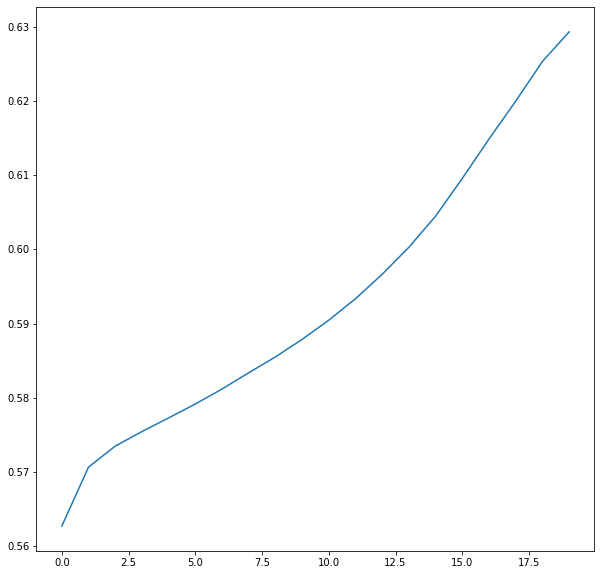

In [20]:
f, axarr = plt.subplots(1, 1, figsize=(10, 10))
axarr.plot(val_aucs)

### Privacy Loss

In [21]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=outputs, indices=s_labels, noise_eps=.2, delta=1e-5)
print(f"Data Dependent Analysis: {str(data_dep_eps)}")
print(f"Data Independent Analysis: {str(data_ind_eps)}")

Data Dependent Analysis: 1056.050596826109
Data Independent Analysis: 2779.0329254649705
